In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import numpy as np

In [2]:
AVOGADROS_NUMBER = 6.022140857e23
HARTREE_TO_EV = 27.211386024367243
EV_TO_JOULE = 1.6021766208e-19
JOULE_TO_KCAL = 1 / 4184.0
HARTREE_TO_JOULE = HARTREE_TO_EV * EV_TO_JOULE
HARTREE_TO_KCALPERMOL = HARTREE_TO_JOULE * JOULE_TO_KCAL * AVOGADROS_NUMBER

def hartree2kcalpermol(x):
    r"""Hartree to kJ/mol conversion factor from CODATA 2014"""
    return x * HARTREE_TO_KCALPERMOL

In [3]:
df = pd.read_parquet('2xr_comp6v1_energies-forces_full.pq')
df.iloc[0]

id                                         ANI-BenchMD-wB97X-631Gd/020-0-idx0
species                     [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...
dataset_energy                                                    -515.315901
dataset_force_magnitudes    [0.0703279972076416, 0.04193009436130524, 0.04...
energy_mean                                                        -515.31488
energy_qbc                                                           0.000137
atomic_energies             [[-0.17821046710014343, -0.1493115872144699, -...
mean_atomic_energies        [-0.17422795295715332, -0.15452808141708374, -...
stdev_atomic_energies       [0.002816656371578574, 0.0024398323148489, 0.0...
force_magnitudes            [[0.07671252638101578, 0.03992581367492676, 0....
force_relative_stdev        [0.017814481630921364, 0.08636333793401718, 0....
force_relative_range        [0.05304139107465744, 0.23753350973129272, 0.1...
mean_relative_stdev                                             

In [4]:
atom_types = {1: "H", 6: "C", 7: "N", 8: "O"}

df["energy_mean"] = df["energy_mean"].apply(hartree2kcalpermol)
df["energy_qbc"] = df["energy_qbc"].apply(hartree2kcalpermol)
df["dataset_energy"] = df["dataset_energy"].apply(hartree2kcalpermol)

df["atomic_energies"] = df["atomic_energies"].apply(lambda x: [hartree2kcalpermol(e) for e in x])
df["mean_atomic_energies"] = df["mean_atomic_energies"].apply(lambda x: [hartree2kcalpermol(e) for e in x])
df["stdev_atomic_energies"] = df["stdev_atomic_energies"].apply(lambda x: [hartree2kcalpermol(e) for e in x])

df["force_magnitudes"] = df["force_magnitudes"].apply(lambda x: [hartree2kcalpermol(f) for f in x])
df["mean_force_mag"] = df["force_magnitudes"].apply(lambda x: np.mean(np.array(x), axis=0))
df["dataset_force_magnitudes"] = df["dataset_force_magnitudes"].apply(lambda x: [hartree2kcalpermol(f) for f in x])

df["energy_error"] = abs(df["dataset_energy"] - df["energy_mean"])
df["weighted_energy_error"] = np.abs(df["dataset_energy"] - df["energy_mean"]) / np.abs(df["dataset_energy"])

print("All energies and forces converted to kcal/mol!")

All energies and forces converted to kcal/mol!


In [5]:
df.iloc[:]['mean_relative_stdev'].mean()

np.float64(0.08260423253153329)

In [6]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (6.5, 4)
plt.rcParams["figure.dpi"] = 150

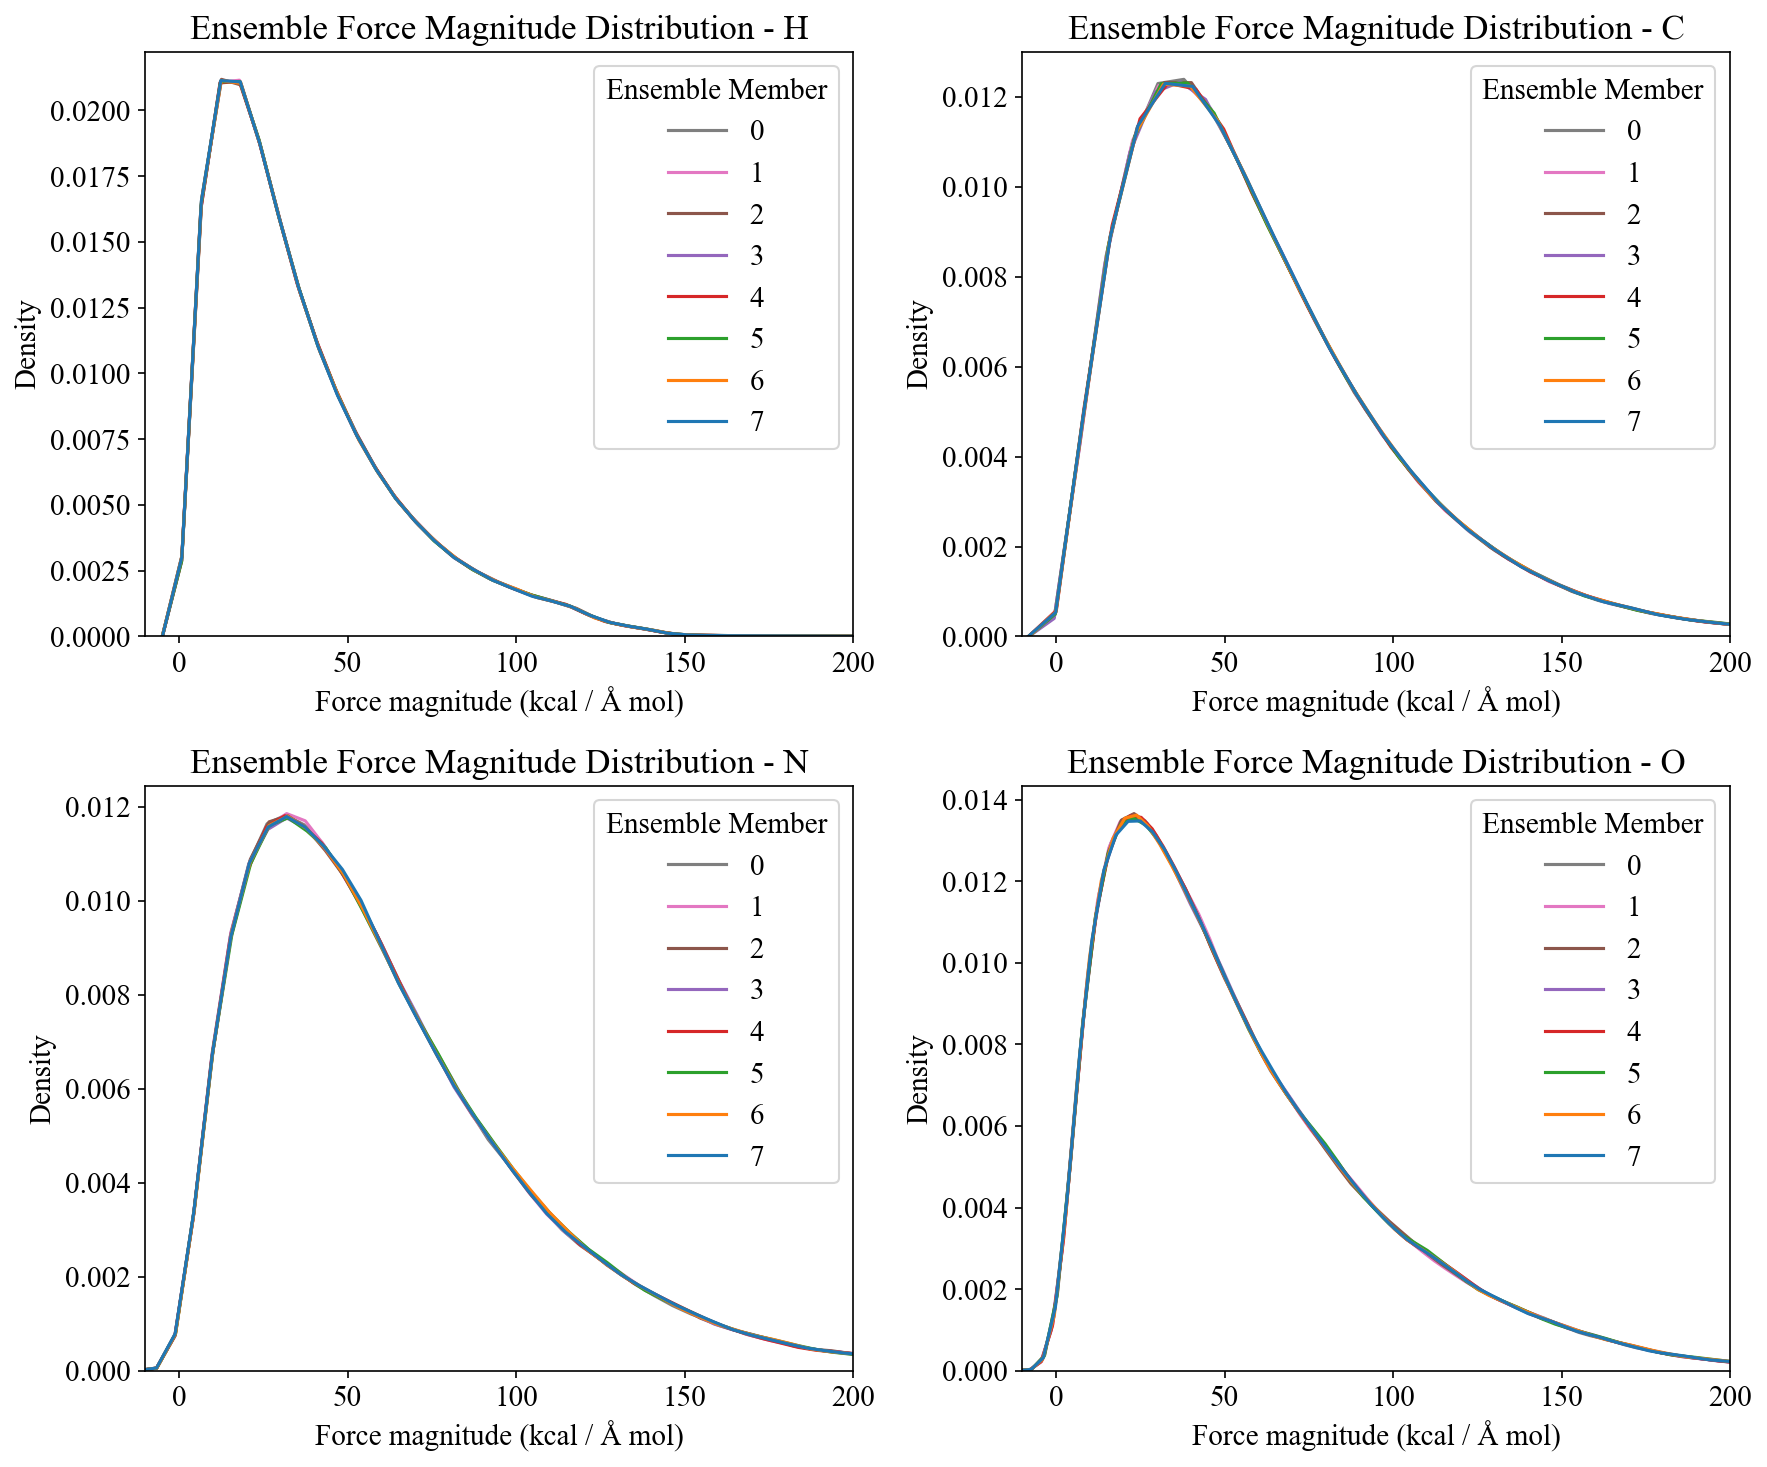

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

long_force_mag = []

for _, row in df.iterrows():
    species = row["species"]
    for i in range(8):  # 8 ensemble members
        force_magnitudes = row["force_magnitudes"][i]  # Shape [N_atoms]
        for atom_idx, energy in enumerate(force_magnitudes):
            long_force_mag.append([row["id"], i, species[atom_idx], energy])

df_long_force_mag = None
df_long_force_mag = pd.DataFrame(long_force_mag, columns=["id", "ensemble_member", "species", "force_magnitudes"])

for idx, (atom_num, atom_name) in enumerate(atom_types.items()):
    ax = axes[idx]

    df_filtered = df_long_force_mag[df_long_force_mag["species"] == atom_num]

    sns.kdeplot(data=df_filtered, x="force_magnitudes", hue="ensemble_member", ax=ax, palette="tab10", common_norm=False)
    ax.set_xlim(-10,200)
    ax.set_xlabel("Force magnitude (kcal / Å mol)")
    ax.set_ylabel("Density")
    ax.set_title(f"Ensemble Force Magnitude Distribution - {atom_name}")
    ax.legend(title="Ensemble Member", labels=df_long_force_mag["ensemble_member"].unique())

plt.tight_layout()
plt.show()


In [8]:
df.iloc[0]

id                                         ANI-BenchMD-wB97X-631Gd/020-0-idx0
species                     [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...
dataset_energy                                                 -323365.609936
dataset_force_magnitudes    [44.131484527495964, 26.311531452815576, 25.28...
energy_mean                                                    -323364.969469
energy_qbc                                                           0.085878
atomic_energies             [[-111.82875645168036, -93.6944355386146, -108...
mean_atomic_energies        [-109.32969109705364, -96.9678350712464, -106....
stdev_atomic_energies       [1.767478557857843, 1.5310178922703555, 1.7671...
force_magnitudes            [[48.13783707011457, 25.053826333778574, 28.62...
force_relative_stdev        [0.017814481630921364, 0.08636333793401718, 0....
force_relative_range        [0.05304139107465744, 0.23753350973129272, 0.1...
mean_relative_stdev                                             

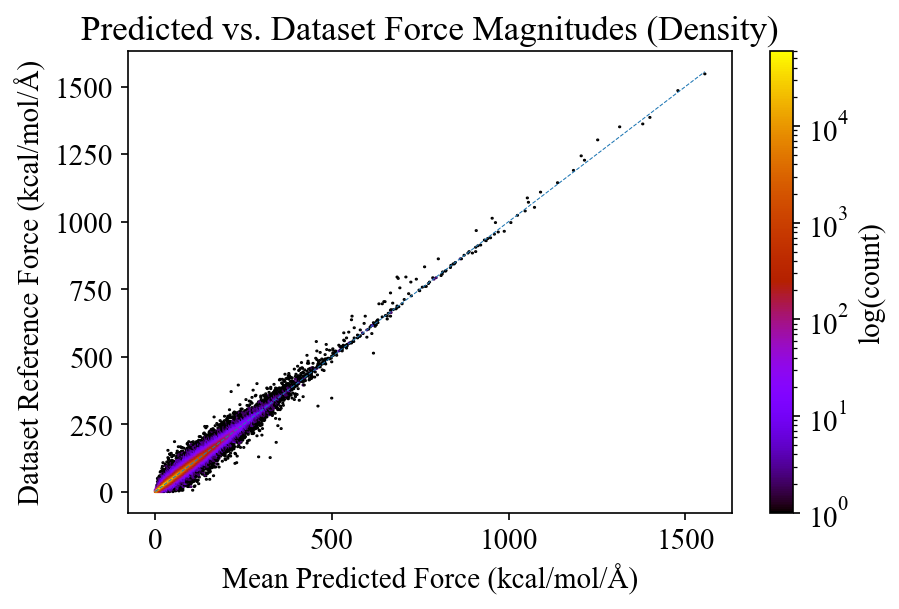

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

force_pairs = [
    (pred, ref)
    for pred_list, ref_list in zip(df["mean_force_mag"], df["dataset_force_magnitudes"])
    for pred, ref in zip(pred_list, ref_list)  # Unpacking per atom
]

pred_forces, ref_forces = map(np.array, zip(*force_pairs))

plt.hexbin(pred_forces, ref_forces, gridsize=500, cmap="gnuplot", bins="log")
plt.colorbar(label="log(count)")


plt.xlabel("Mean Predicted Force (kcal/mol/Å)")
plt.ylabel("Dataset Reference Force (kcal/mol/Å)")
plt.title("Predicted vs. Dataset Force Magnitudes (Density)")

min_force, max_force = min(pred_forces), max(pred_forces)
plt.plot([min_force, max_force], [min_force, max_force], linewidth=0.5, linestyle="--")

plt.show()


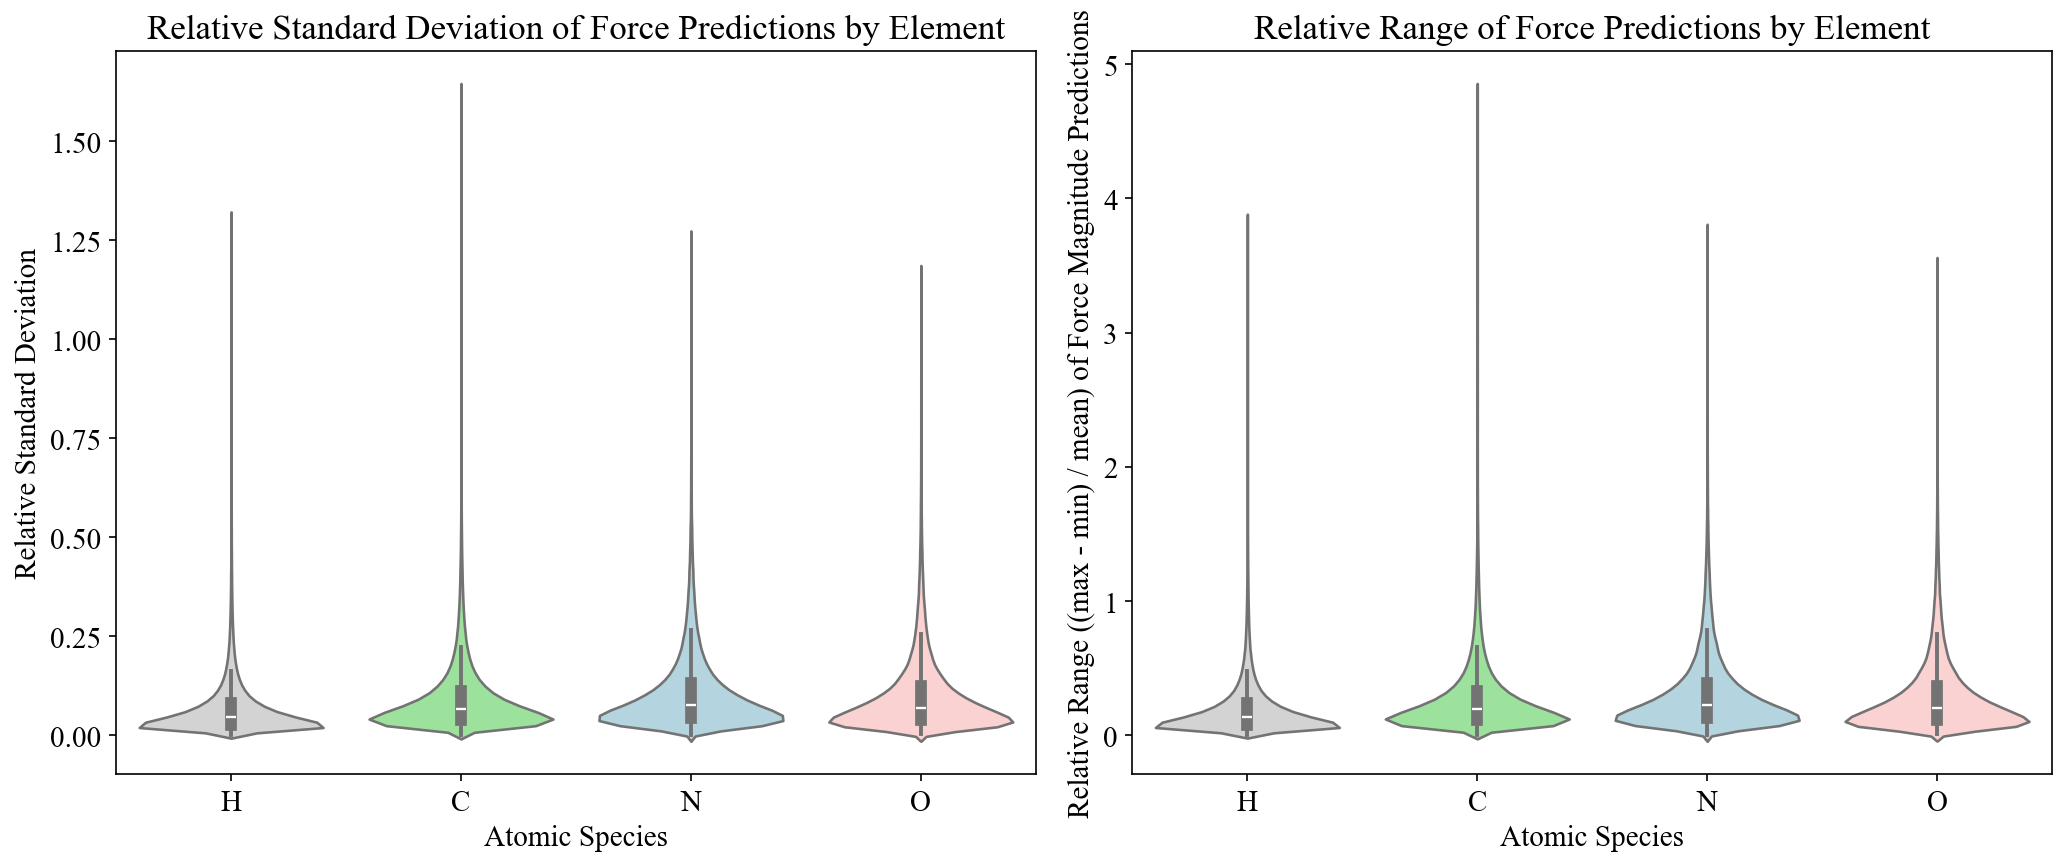

In [10]:
atom_types_colors = {
    1: ("H", "#d3d3d3"),   # Light Grey
    6: ("C", "#90ee90"),   # Light Green
    7: ("N", "#add8e6"),   # Light Blue
    8: ("O", "#ffcccb")    # Light Red
}
df_long_stdev = df.explode("force_relative_stdev").reset_index(drop=True)
df_long_stdev["species"] = df.explode("species")["species"].reset_index(drop=True)
df_long_stdev["species"] = df_long_stdev["species"].map(lambda x: atom_types_colors.get(x, ("Unknown", "black"))[0])

df_long_range = df.explode("force_relative_range").reset_index(drop=True)
df_long_range["species"] = df.explode("species")["species"].reset_index(drop=True)
df_long_range["species"] = df_long_range["species"].map(lambda x: atom_types_colors.get(x, ("Unknown", "black"))[0])

species_color_map = {v[0]: v[1] for v in atom_types_colors.values()}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.violinplot(ax=axes[0], data=df_long_stdev, x="species", y="force_relative_stdev", 
               hue="species", palette=species_color_map, order=['H', 'C', 'N', 'O'])

axes[0].set_xlabel("Atomic Species")
axes[0].set_ylabel("Relative Standard Deviation")
axes[0].set_title("Relative Standard Deviation of Force Predictions by Element")

sns.violinplot(ax=axes[1], data=df_long_range, x="species", y="force_relative_range", 
               hue="species", palette=species_color_map, order=['H', 'C', 'N', 'O'])

axes[1].set_xlabel("Atomic Species")
axes[1].set_ylabel("Relative Range ((max - min) / mean) of Force Magnitude Predictions")
axes[1].set_title("Relative Range of Force Predictions by Element")


plt.tight_layout()
plt.show()

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define weight function (exponential to emphasize high-force atoms)
def compute_weighted_average(values, weights, alpha=1.0):
    """Compute weighted mean with exponential weighting."""
    exp_weights = np.exp(alpha * np.array(weights))  # Exponential weighting
    return np.sum(np.array(values) * exp_weights) / np.sum(exp_weights)

# Compute weighted averages for each molecule
weighted_stdev = []
weighted_range = []

for _, row in df.iterrows():
    # Compute weighted averages using force magnitudes as weights
    weighted_stdev.append(compute_weighted_average(row["force_relative_stdev"], row["mean_force_mag"], alpha=0.1))
    weighted_range.append(compute_weighted_average(row["force_relative_range"], row["mean_force_mag"], alpha=0.1))

# Store in DataFrame
df["weighted_force_stdev"] = weighted_stdev
df["weighted_force_range"] = weighted_range


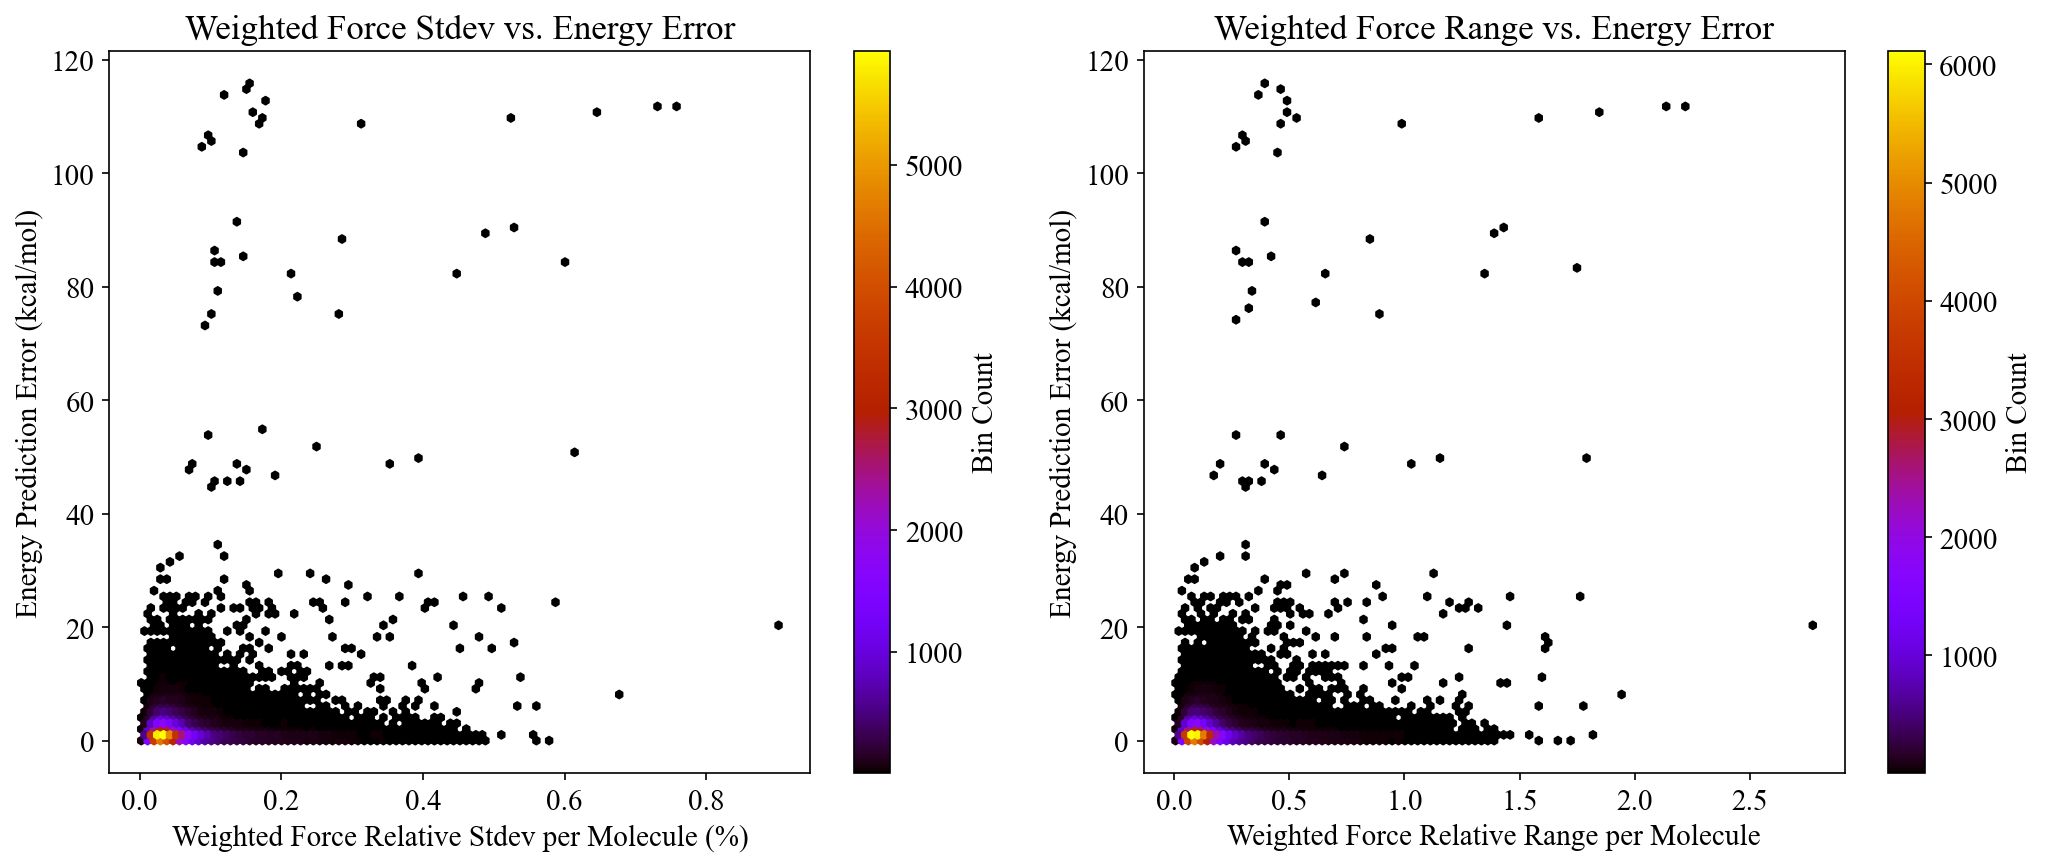

In [12]:
x_stdev = df["weighted_force_stdev"]
x_range = df["weighted_force_range"]
y_error = df["energy_error"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

hb1 = axes[0].hexbin(x_stdev, y_error, gridsize=100, cmap="gnuplot", mincnt=1)
axes[0].set_xlabel("Weighted Force Relative Stdev per Molecule (%)")
axes[0].set_ylabel("Energy Prediction Error (kcal/mol)")
axes[0].set_title("Weighted Force Stdev vs. Energy Error")
cb1 = fig.colorbar(hb1, ax=axes[0])
cb1.set_label("Bin Count")

hb2 = axes[1].hexbin(x_range, y_error, gridsize=100, cmap="gnuplot", mincnt=1)
axes[1].set_xlabel("Weighted Force Relative Range per Molecule")
axes[1].set_ylabel("Energy Prediction Error (kcal/mol)")
axes[1].set_title("Weighted Force Range vs. Energy Error")
cb2 = fig.colorbar(hb2, ax=axes[1])
cb2.set_label("Bin Count")

plt.tight_layout()
plt.show()


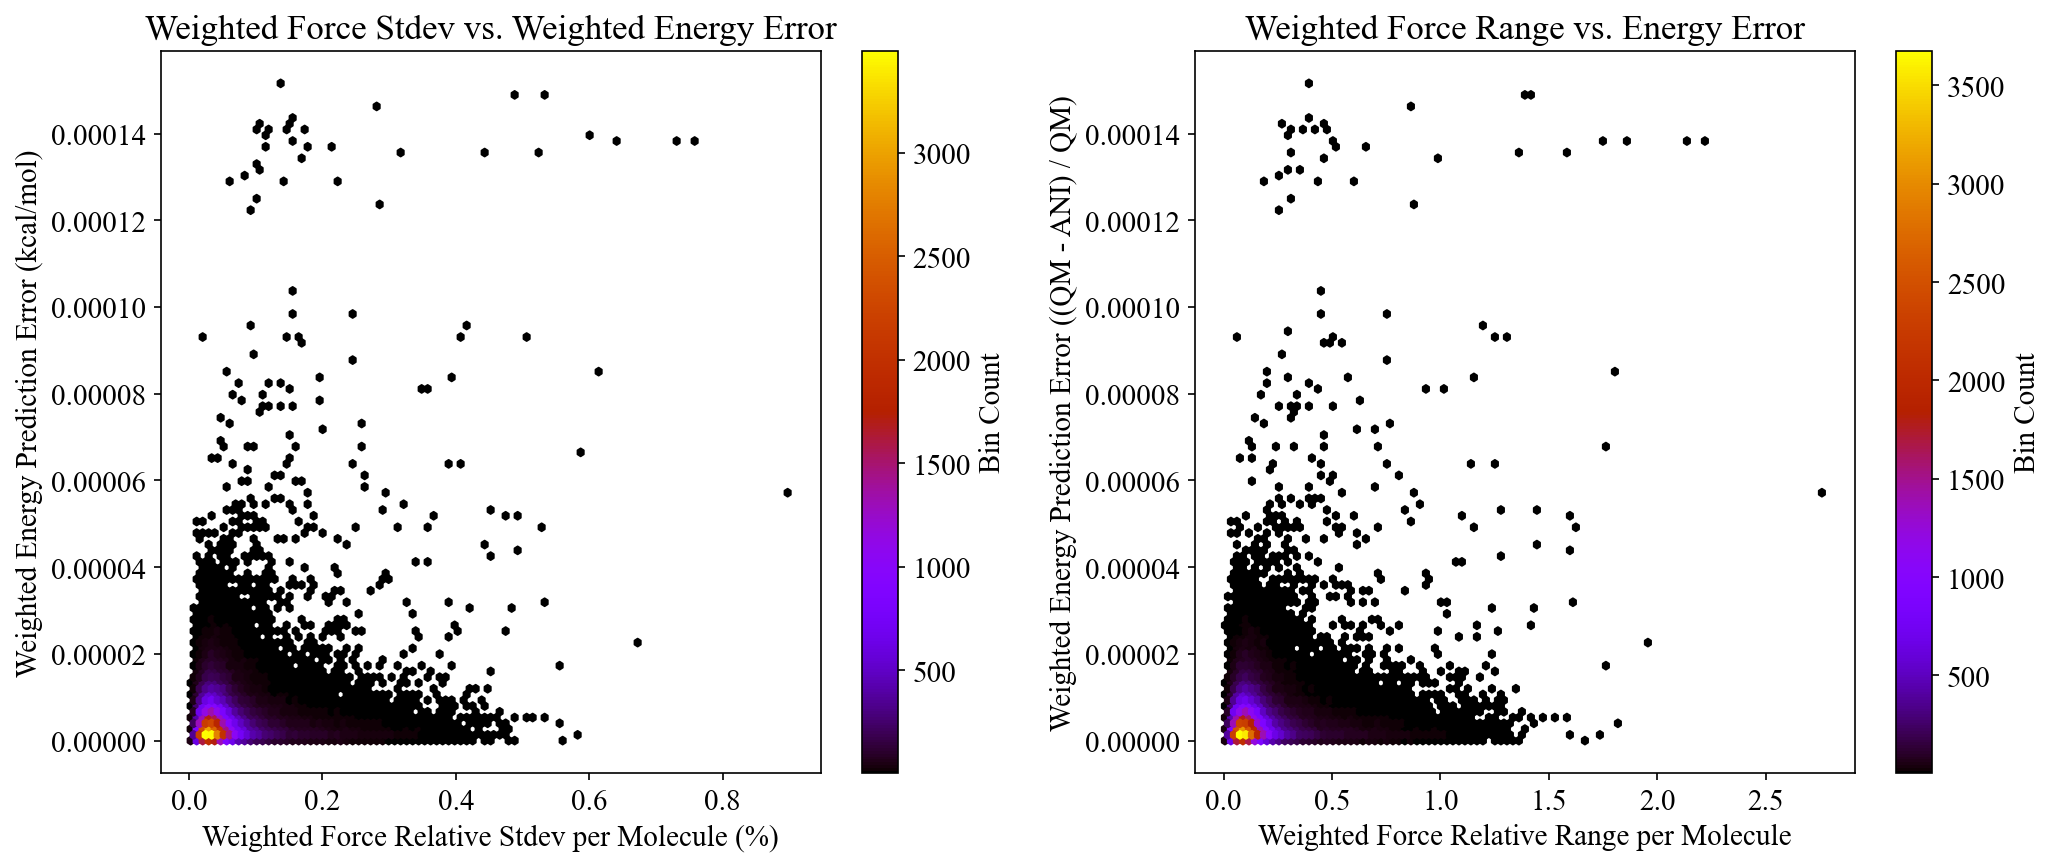

In [13]:
x_stdev = df["weighted_force_stdev"]
x_range = df["weighted_force_range"]
y_error = df["weighted_energy_error"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

hb1 = axes[0].hexbin(x_stdev, y_error, gridsize=100, cmap="gnuplot", mincnt=1)
axes[0].set_xlabel("Weighted Force Relative Stdev per Molecule (%)")
axes[0].set_ylabel("Weighted Energy Prediction Error (kcal/mol)")
axes[0].set_title("Weighted Force Stdev vs. Weighted Energy Error")
cb1 = fig.colorbar(hb1, ax=axes[0])
cb1.set_label("Bin Count")

hb2 = axes[1].hexbin(x_range, y_error, gridsize=100, cmap="gnuplot", mincnt=1)
axes[1].set_xlabel("Weighted Force Relative Range per Molecule")
axes[1].set_ylabel("Weighted Energy Prediction Error ((QM - ANI) / QM)")
axes[1].set_title("Weighted Force Range vs. Energy Error")
cb2 = fig.colorbar(hb2, ax=axes[1])
cb2.set_label("Bin Count")

plt.tight_layout()
plt.show()


In [14]:
df.iloc[0]

id                                         ANI-BenchMD-wB97X-631Gd/020-0-idx0
species                     [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...
dataset_energy                                                 -323365.609936
dataset_force_magnitudes    [44.131484527495964, 26.311531452815576, 25.28...
energy_mean                                                    -323364.969469
energy_qbc                                                           0.085878
atomic_energies             [[-111.82875645168036, -93.6944355386146, -108...
mean_atomic_energies        [-109.32969109705364, -96.9678350712464, -106....
stdev_atomic_energies       [1.767478557857843, 1.5310178922703555, 1.7671...
force_magnitudes            [[48.13783707011457, 25.053826333778574, 28.62...
force_relative_stdev        [0.017814481630921364, 0.08636333793401718, 0....
force_relative_range        [0.05304139107465744, 0.23753350973129272, 0.1...
mean_relative_stdev                                             

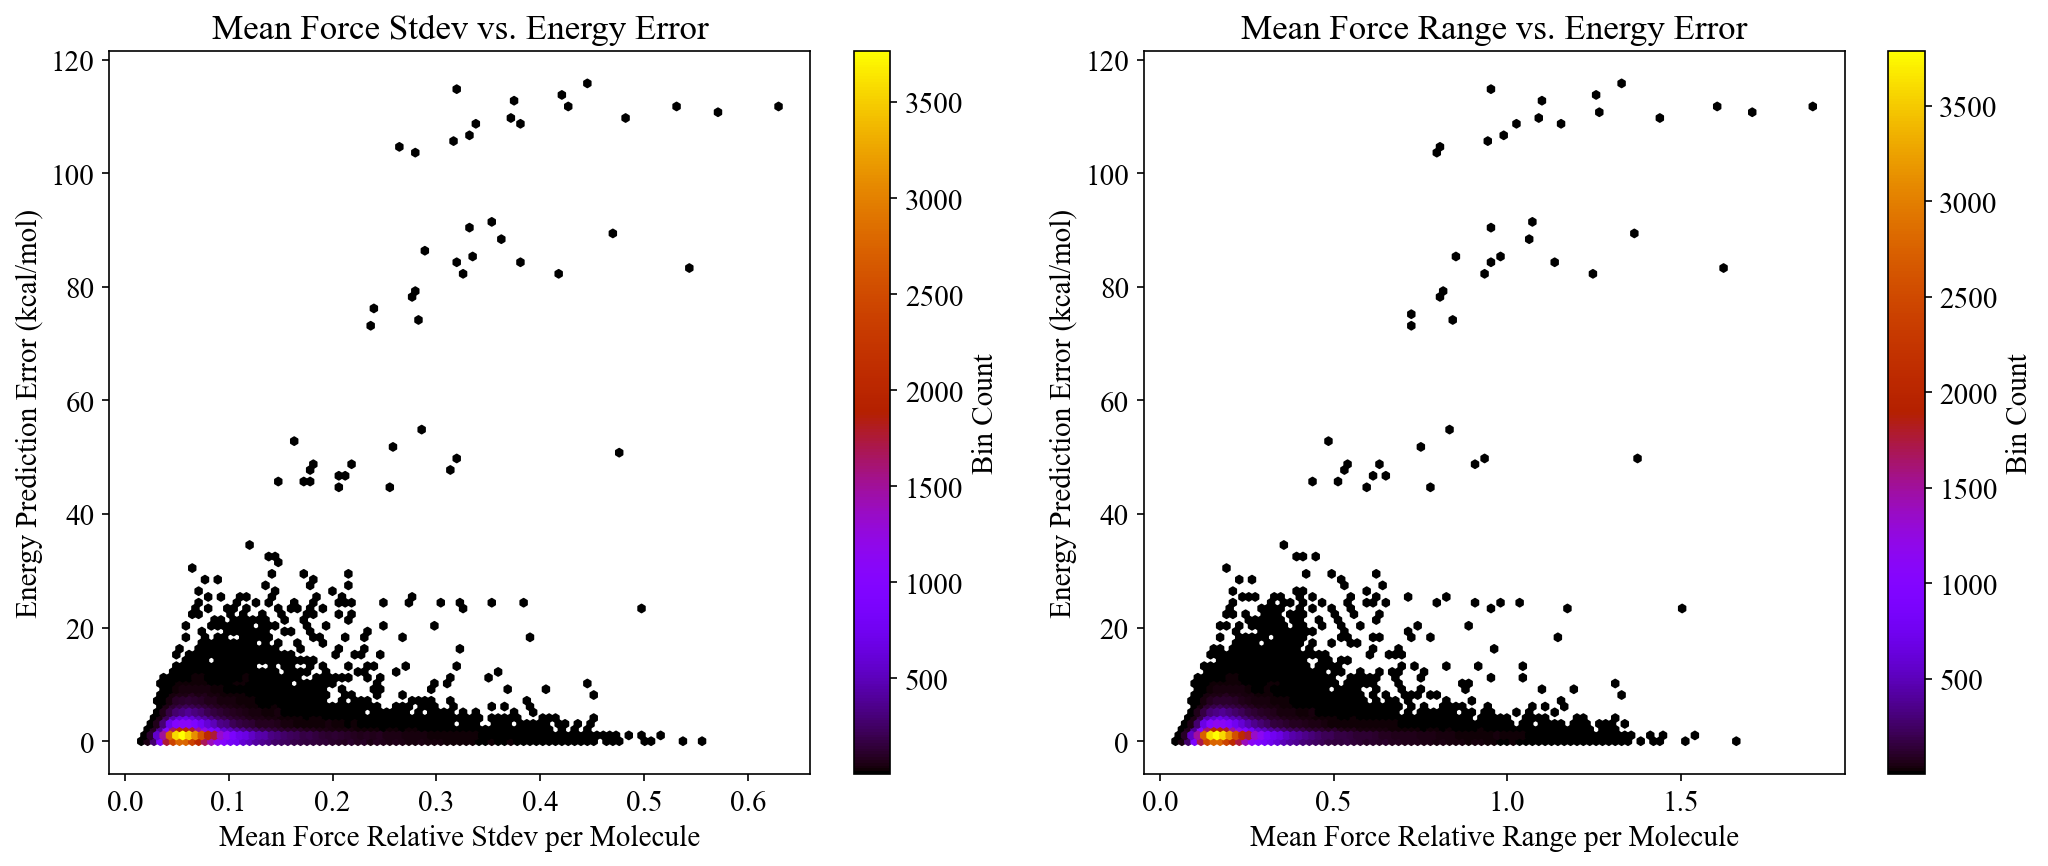

In [15]:
x_stdev = df["mean_relative_stdev"]
x_range = df["mean_relative_range"]
y_error = df["energy_error"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

hb1 = axes[0].hexbin(x_stdev, y_error, gridsize=100, cmap="gnuplot", mincnt=1)
axes[0].set_xlabel("Mean Force Relative Stdev per Molecule")
axes[0].set_ylabel("Energy Prediction Error (kcal/mol)")
axes[0].set_title("Mean Force Stdev vs. Energy Error")
cb1 = fig.colorbar(hb1, ax=axes[0])
cb1.set_label("Bin Count")

hb2 = axes[1].hexbin(x_range, y_error, gridsize=100, cmap="gnuplot", mincnt=1)
axes[1].set_xlabel("Mean Force Relative Range per Molecule")
axes[1].set_ylabel("Energy Prediction Error (kcal/mol)")
axes[1].set_title("Mean Force Range vs. Energy Error")
cb2 = fig.colorbar(hb2, ax=axes[1])
cb2.set_label("Bin Count")

plt.tight_layout()
plt.show()

In [16]:
df.iloc[0]

id                                         ANI-BenchMD-wB97X-631Gd/020-0-idx0
species                     [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...
dataset_energy                                                 -323365.609936
dataset_force_magnitudes    [44.131484527495964, 26.311531452815576, 25.28...
energy_mean                                                    -323364.969469
energy_qbc                                                           0.085878
atomic_energies             [[-111.82875645168036, -93.6944355386146, -108...
mean_atomic_energies        [-109.32969109705364, -96.9678350712464, -106....
stdev_atomic_energies       [1.767478557857843, 1.5310178922703555, 1.7671...
force_magnitudes            [[48.13783707011457, 25.053826333778574, 28.62...
force_relative_stdev        [0.017814481630921364, 0.08636333793401718, 0....
force_relative_range        [0.05304139107465744, 0.23753350973129272, 0.1...
mean_relative_stdev                                             

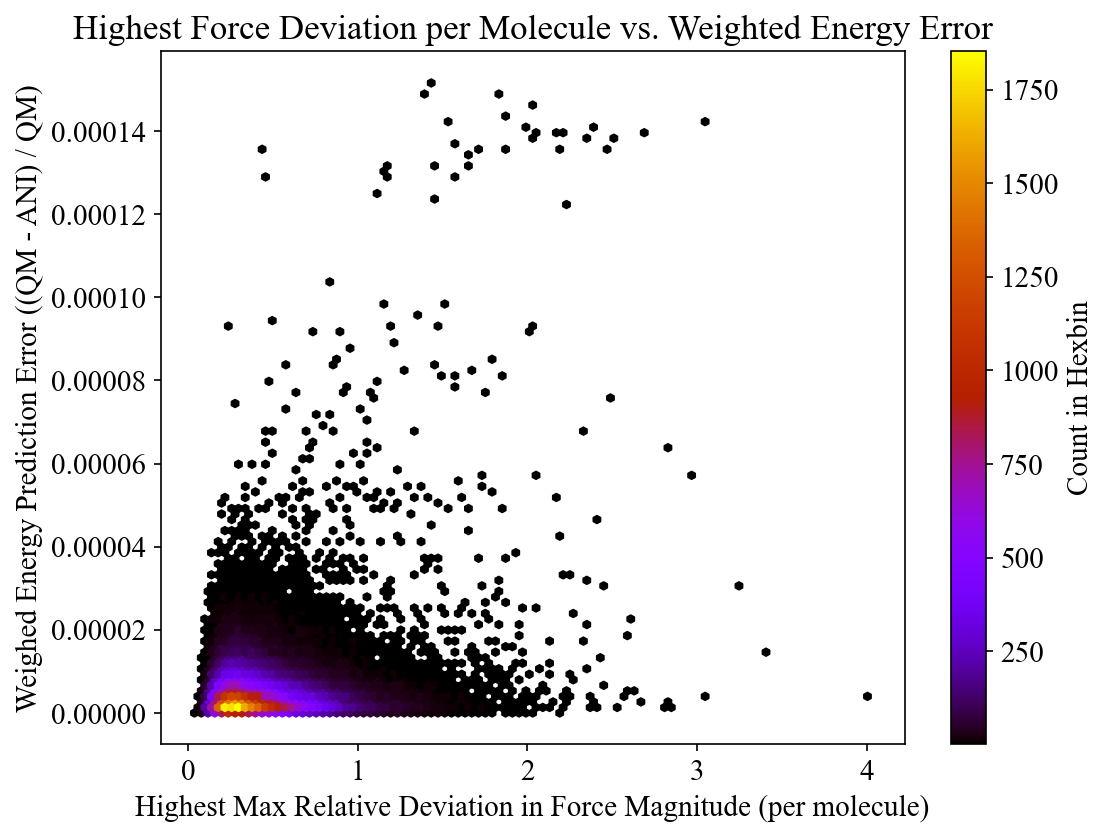

In [17]:
relative_max_deviations = []

for _, row in df.iterrows():
    species = row["species"]  # Atomic species per atom
    force_magnitudes = np.array(row["force_magnitudes"])  # Shape: (8, N_atoms)
    mean_force = np.mean(force_magnitudes, axis=0)  # Mean over ensemble, shape: (N_atoms,)

    mean_force[mean_force == 0] = np.nan  # Set zeros to NaN to avoid division errors

    max_relative_deviation = np.nanmax(np.abs(force_magnitudes - mean_force) / mean_force, axis=0)

    for atom_idx, rel_deviation in enumerate(max_relative_deviation):
        relative_max_deviations.append([
            row["id"], species[atom_idx], rel_deviation, row["weighted_energy_error"]
        ])

df_relative_max_dev = pd.DataFrame(
    relative_max_deviations, columns=["id", "species", "max_relative_force_deviation", "weighted_energy_error"]
)

df_max_per_molecule = df_relative_max_dev.loc[
    df_relative_max_dev.groupby("id")["max_relative_force_deviation"].idxmax()
]

plt.figure(figsize=(8, 6))
hb = plt.hexbin(
    df_max_per_molecule["max_relative_force_deviation"], 
    df_max_per_molecule["weighted_energy_error"], 
    gridsize=100, cmap="gnuplot", mincnt=1
)

plt.colorbar(hb, label="Count in Hexbin")
plt.xlabel("Highest Max Relative Deviation in Force Magnitude (per molecule)")
plt.ylabel("Weighed Energy Prediction Error ((QM - ANI) / QM)")
plt.title("Highest Force Deviation per Molecule vs. Weighted Energy Error")
plt.show()


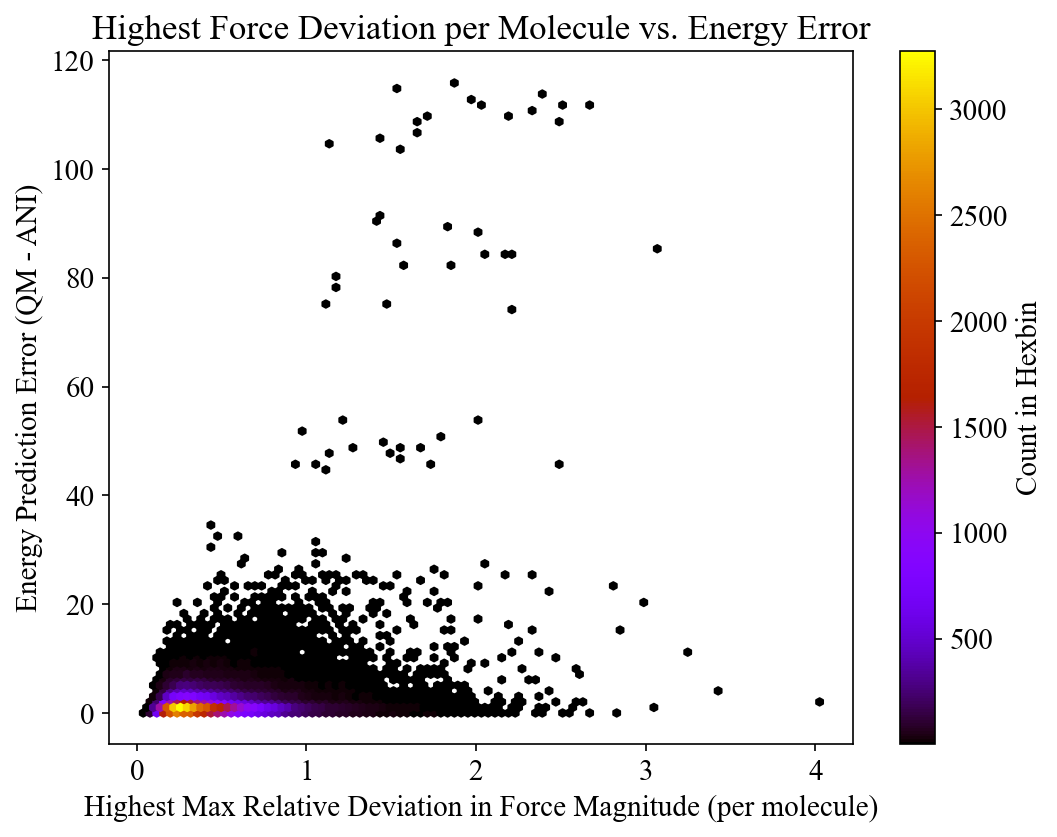

In [18]:
relative_max_deviations = []

for _, row in df.iterrows():
    species = row["species"]  # Atomic species per atom
    force_magnitudes = np.array(row["force_magnitudes"])  # Shape: (8, N_atoms)
    mean_force = np.mean(force_magnitudes, axis=0)  # Mean over ensemble, shape: (N_atoms,)

    mean_force[mean_force == 0] = np.nan  # Set zeros to NaN to avoid division errors

    max_relative_deviation = np.nanmax(np.abs(force_magnitudes - mean_force) / mean_force, axis=0)

    for atom_idx, rel_deviation in enumerate(max_relative_deviation):
        relative_max_deviations.append([
            row["id"], species[atom_idx], rel_deviation, row["energy_error"]
        ])

df_relative_max_dev = pd.DataFrame(
    relative_max_deviations, columns=["id", "species", "max_relative_force_deviation", "energy_error"]
)

df_max_per_molecule = df_relative_max_dev.loc[
    df_relative_max_dev.groupby("id")["max_relative_force_deviation"].idxmax()
]

plt.figure(figsize=(8, 6))
hb = plt.hexbin(
    df_max_per_molecule["max_relative_force_deviation"], 
    df_max_per_molecule["energy_error"], 
    gridsize=100, cmap="gnuplot", mincnt=1
)

plt.colorbar(hb, label="Count in Hexbin")
plt.xlabel("Highest Max Relative Deviation in Force Magnitude (per molecule)")
plt.ylabel("Energy Prediction Error (QM - ANI)")
plt.title("Highest Force Deviation per Molecule vs. Energy Error")
plt.show()


In [20]:
cos_sim = pd.read_parquet('2xr_cos_sim-mag_df-comp6v1.pq')
cos_sim = cos_sim.reset_index().explode(['Difference', 'Mean Cos Sim', 'Species']).set_index('Species')

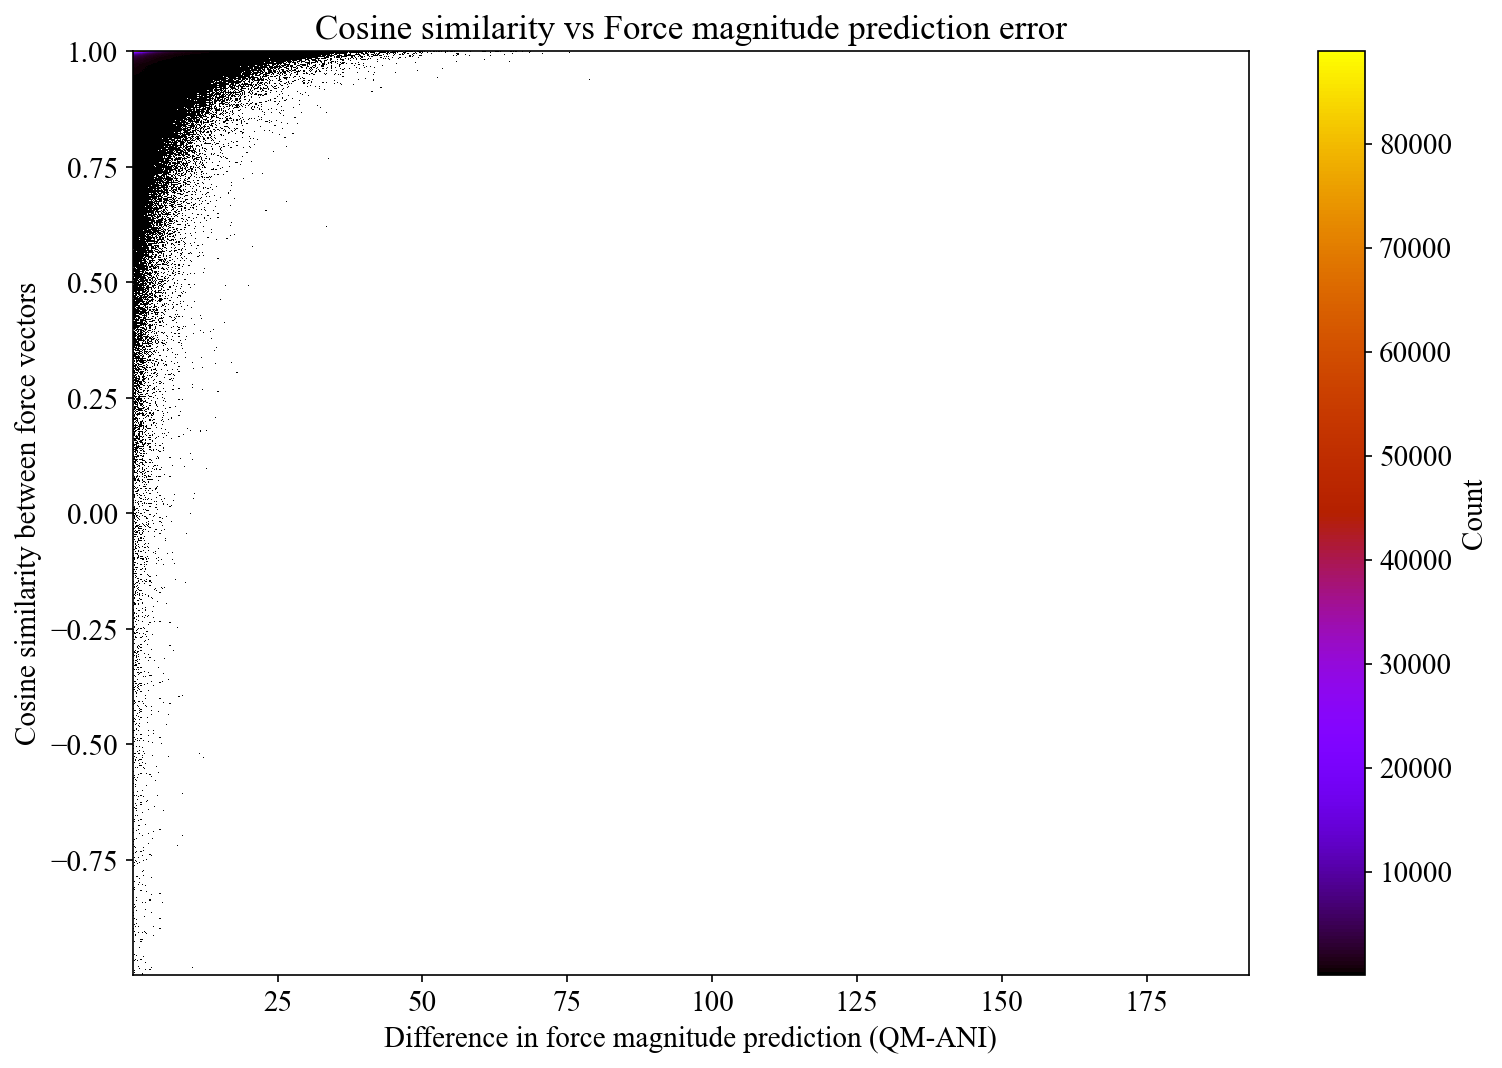

In [87]:
plt.figure(figsize=(12, 8))
hb = plt.hist2d(
    cos_sim["Difference"], 
    cos_sim["Mean Cos Sim"], 
    bins=1000, cmap="gnuplot", cmin=1.5,
)
plt.colorbar(hb[3], label="Count")

plt.xlabel("Difference in force magnitude prediction (QM-ANI)")
plt.ylabel("Cosine similarity between force vectors")
plt.title("Cosine similarity vs Force magnitude prediction error")
plt.show()

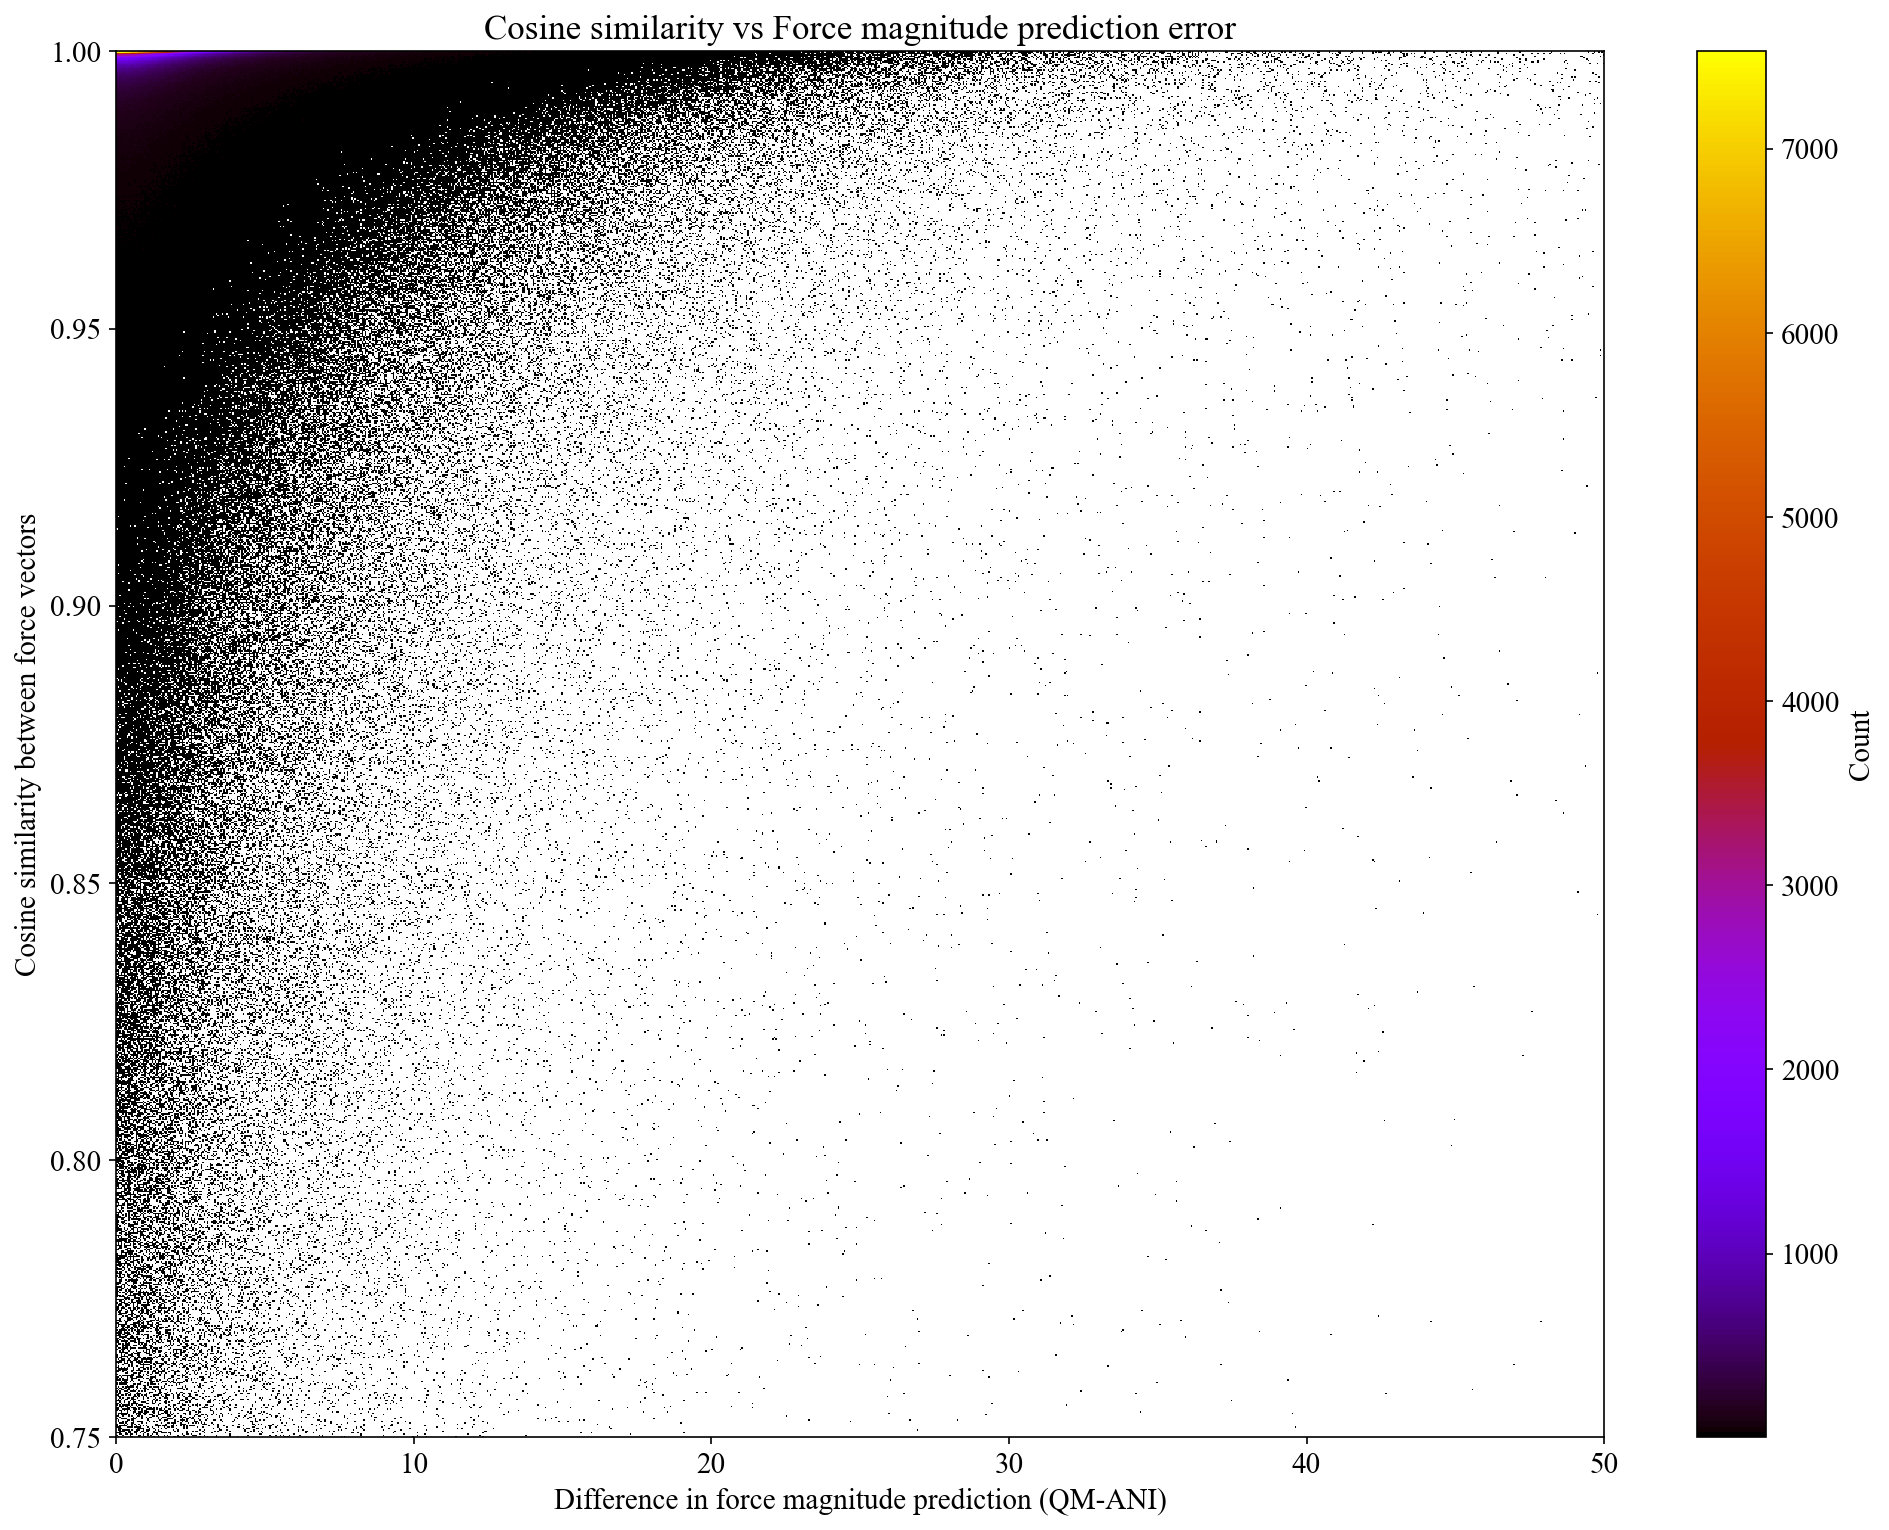

In [81]:
plt.figure(figsize=(16, 12))
hb = plt.hist2d(
    cos_sim["Difference"], 
    cos_sim["Mean Cos Sim"], 
    bins=1000, cmap="gnuplot", cmin=1,
    range=[[0,50],[0.75,1]]
)
plt.colorbar(hb[3], label="Count")

plt.xlabel("Difference in force magnitude prediction (QM-ANI)")
plt.ylabel("Cosine similarity between force vectors")
plt.title("Cosine similarity vs Force magnitude prediction error")
plt.show()

In [45]:
atom_types_colors = {
    1: ("H", "#d3d3d3"),   # Light Grey
    6: ("C", "#90ee90"),   # Light Green
    7: ("N", "#add8e6"),   # Light Blue
    8: ("O", "#ffcccb")    # Light Red
}

cos_sim_plot = cos_sim.reset_index()
cos_sim_plot["Species"] = cos_sim_plot["Species"].map(lambda x: atom_types_colors.get(x, ("Unknown", "#000000"))[0])

species_color_map = {v[0]: v[1] for v in atom_types_colors.values()}


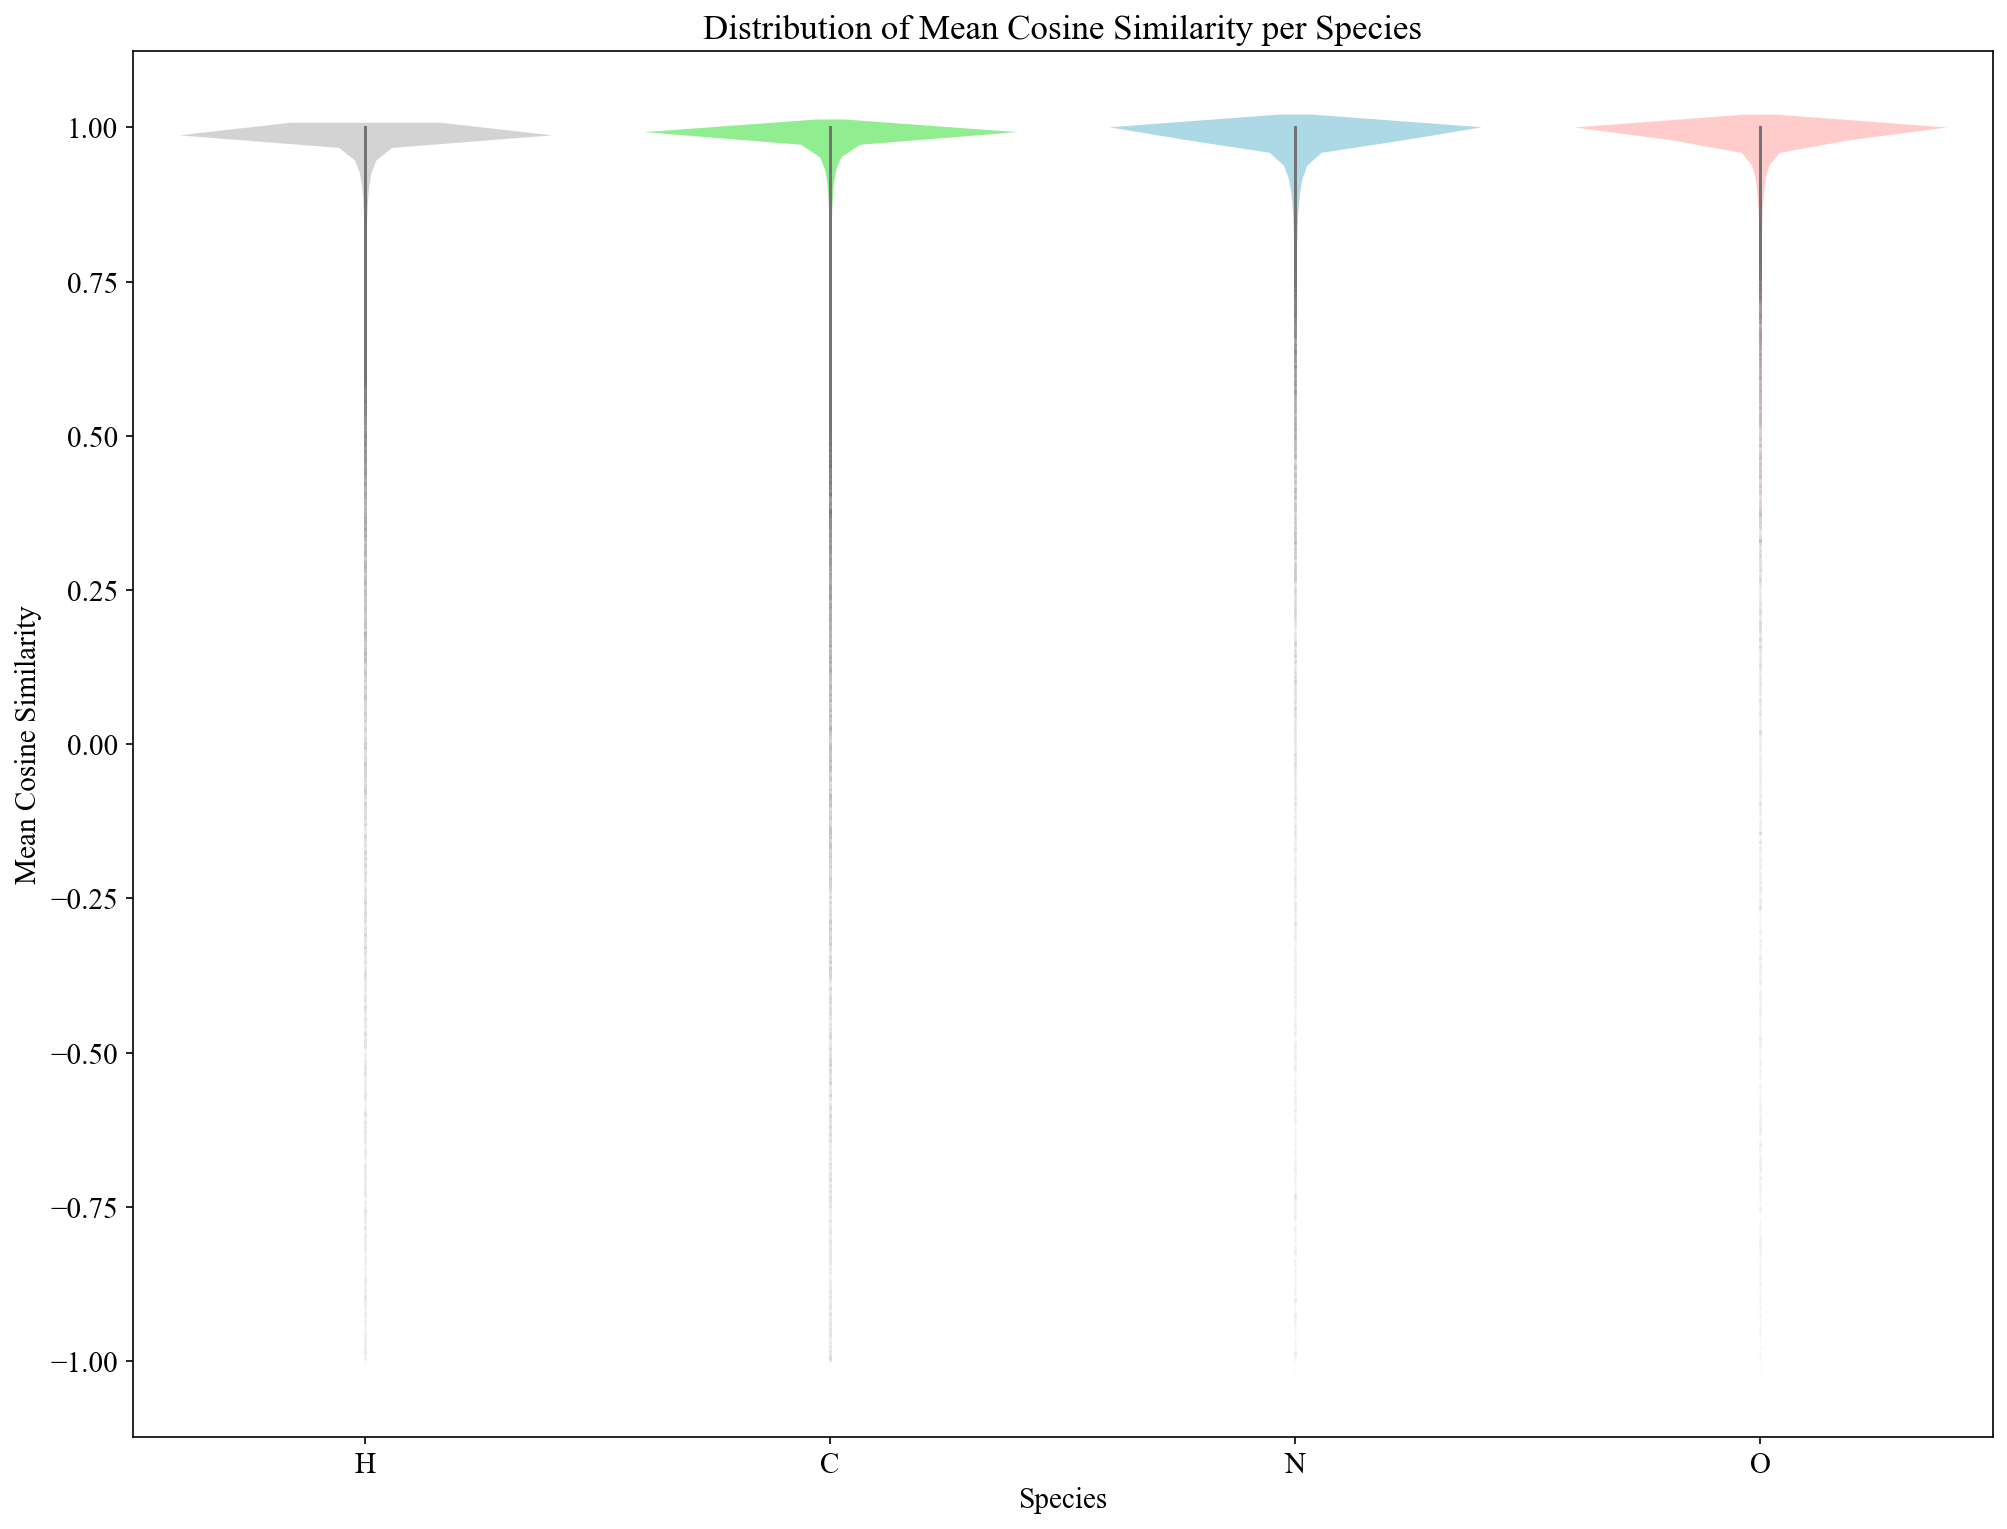

In [76]:
plt.figure(figsize=(16, 12))
sns.violinplot(data=cos_sim_plot, x="Species", y="Mean Cos Sim", inner="point", 
               hue="Species", palette=species_color_map, order=['H', 'C', 'N', 'O'], saturation=1,
               linewidth=0.005, density_norm='count', bw_adjust=1)

plt.xlabel("Species")
plt.ylabel("Mean Cosine Similarity")
plt.title("Distribution of Mean Cosine Similarity per Species")
#plt.xticks(rotation=45)  # Rotate x-axis labels if there are many species
#plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


In [36]:
print(len(cos_sim_plot))

2608858
